# Plotting for Rome poster
_____

### Plotting all LFP channels

In [46]:
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
import datetime as dt
from scipy.io import loadmat
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import gridspec
from scipy.signal import spectrogram
import scipy.stats as stats
import seaborn as sns
from scipy.io import loadmat, savemat

%cd /media/Projects/Adrian/seizureProcessing/
from seizureProcessing.utils.get_chnames import *
from seizureProcessing.utils.get_directories import *
from seizureProcessing.utils.readMatfile import *
from seizureProcessing.utils.get_patinfo_from_path import *



%cd /media/Projects/Adrian/SD_analysis/

from sd_calculation import *
from filesystem_handlers import *

/media/Projects/Adrian/seizureProcessing
/media/Projects/Adrian/SD_analysis


### Figure 1

In [309]:
def rem(x):
    '''helper function
    returns integer from an alphanumerical str
    '''
    return int(''.join(c for c in x if c.isdigit()))


def plot_reref_lfp(path, offset=0, duration=479, mode='datetime', save=True, title=True, label='', form='png'):
    '''plot rereferenced micro channels
    
    Args:
    path: os.path or str, path to data
    '''
    savepath='/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'
    linecolor = 'blue'
    #Fix path ending eith /
    if os.path.basename(path) == '':
        path = os.path.split(path)[0]
    
    #get path to reref data
    reref_path = find_dir(path, 'reref')
    
    if path and len(os.listdir(reref_path)): #if path exists and reref_path has data
        _, data, times = get_matfile_chnames(reref_path)
        data.sort(key=rem) 
        times.sort(key=rem)
        
    #get the plotting times
    if len(times):
        times_file = readMatfile(os.path.join(reref_path, times[0]))
        timestamps = times_file.reref_times
        scheme = times_file.ref_scheme
    else:
        print(f'no reref_times files in {reref_path}')
        return
    
    #get timestamp data
    if mode == 'datetime':
        datetime_ts = [dt.datetime.utcfromtimestamp(timestamps[i]/1e6) for i in range(len(timestamps))]
    
    ts = [(timestamps[i]-timestamps[0])/1e6 for i, item in enumerate(timestamps)]
    #times = [(ts[i]-ts[0])/1e6 for i, item in enumerate(ts)]
          
    
    y_tick = 0
    y_label = []

    period = offset + duration
    
    #get sampling freq info
    if 'DS_' in path:
        try:
            files_ds, _, __ =  get_matfile_chnames(os.path.split(reref_path)[0])
            #sf_file = loadmat(os.path.join(path,files_ds[0]))
            sf_file = readMatfile(os.path.join(path,files_ds[0]))
            #ds_params = sf_file['get_lfp_params'][0]
            #ds_params = ds_params.split(',')[1]
            #ds_params = ds_params.split('=')[-1]
            #sf = int(ds_params)

            try:
                sf = sf_file.DS_freq
            except AttributeError:
                per = (timestamps[1]-timestamps[0])/1e6
                sf = round(1/per)
            del sf_file
        except FileNotFoundError:
            sf = 1000
    else:
        chnames_ncs = get_chnames(path)
        sf_file = loadNCS(os.path.join(path,chnames_ncs[0]))
        sf = sf_file.sf
        del sf_file
    
    #get offset and period datapoints
    o = max(0, int(offset*sf))
    p = min(len(ts), int((period)*sf))
    
    #initialize plot
    my_dpi = 96
    fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
    #fig = plt.figure(figsize=(9, 8))
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.85])  
    
    y_tick = 0
    y_label = []
    ylabel_maj = []
    
    #plot data
    for ix, ch in enumerate(data):
        #print(f'plotting micro {ch}')
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data #get data from file
        chname = file.chname
        print(f'plotting micro {chname}')
        yplot = data[o:p] - np.mean(data[o:p]) #center around 0
        
        #plot
        if mode == 'datetime':
            ax.plot(ts[o:p], yplot/500+y_tick, lw=0.5, c=linecolor)
        else:
            xplot = np.linspace(0, duration, len(ts[o:p]))
            ax.plot(xplot, yplot/500+y_tick, lw=0.5, c=linecolor)
        
        #get the current label correct
        curr_label = chname
        y_label.append(curr_label[-1])
        ylabel_maj.append(curr_label[:-1])
        
        #change ytick parameters
        y_tick -= 2
        
    print('rendering...') 
    
    #set xaxis params
    if mode == 'datetime':
        ax.set_xlim(min(ts[o:p]), max(ts[o:p]))
        xaxis_min = ((np.arange(min(ts[o:p]), max(ts[o:p]), 10))).tolist()
        xaxis_maj = ((np.arange(min(ts[o:p]), max(ts[o:p]), 60))).tolist()
        ax.set_xticks(xaxis_maj)
        xaxis_maj_2 = datetime_ts[o:p:sf*60]
        labels_yaxis = [(str(a).split(' ')[-1]).split('.')[0] for a in xaxis_maj_2]
        ax.set_xticklabels(labels_yaxis, fontsize=8, fontweight='bold')
        ax.set_xlabel('time (HH:MM:SS)', fontweight='bold', fontsize=12)
        plt.xticks(rotation=45)
    else:
        ax.set_xlim(min(xplot), max(xplot))
        xaxis_min = ((np.arange(min(xplot), max(xplot), 10))).tolist()
        xaxis_maj = ((np.arange(min(xplot), max(xplot), 60))).tolist()
        ax.set_xticks(xaxis_maj)
        ax.set_xticks(xaxis_min, minor=True)
        ax.set_xlabel('time (sec)', fontweight='bold', fontsize=15)
    
    #set yaxis params
    ax.set_ylim(y_tick, 2)
    indexes = np.unique(ylabel_maj, return_index=True)[1]
    ylabel_maj = [ylabel_maj[index] for index in sorted(indexes)]
    yticks = np.arange(int(y_tick +2), 1, 2).tolist()
    yticks_maj = np.arange(y_tick, 2, abs(y_tick/(len(ylabel_maj)*2))).tolist()[1::2]#
    yticks_maj = yticks_maj[::-1]#
    yticks_maj = [x -0.01 for x in yticks_maj] #added to avoid major/minor axis collision
    ax.set_yticks(yticks_maj)#
    ax.set_yticks(yticks, minor=True)#
    ax.set_yticklabels(ylabel_maj, fontsize=15, fontweight='bold', minor=False, rotation='vertical', 
                       x=-0.01, va='center')#
    y_label.reverse()
    fsize = max(7, 480/len(y_label))
    fsize = min(fsize, 12)
    ax.set_yticklabels(y_label, fontsize=fsize, fontweight='bold', minor=True)#
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', reset=False, width=0)
    plt.grid(visible=True, which='minor', axis='x')
    plt.grid(visible=True, which='major', axis='x', linewidth=0.8, color='k')
    
    if mode=='datetime':
        title_datetime_str = dt.datetime.strftime(datetime_ts[o], '%Y-%m-%d_%H-%M-%S')
    else:
        title_datetime_str = dt.datetime.strftime(dt.datetime.utcfromtimestamp(timestamps[o]/1e6), 
                                                  '%Y-%m-%d_%H-%M-%S')
    
    if title:
        #get patient number and seizure number
        expr = re.compile('(.*)(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})(.*)')
        match = expr.search(path)
        session = match.group(2)
        basepath = find_dir(path, session)

        pnr, snr = get_patinfo_from_path(basepath)
        #figure title
        if scheme == 'lca':
            scheme = 'LCA'
        fig.suptitle(f'LFP patient {pnr} seizure {snr} ({title_datetime_str}), {scheme} reference', 
                     fontweight="bold", fontsize=16)
    
    if save:
        print('saving plot...')
        figname = savepath + '/' + title_datetime_str + f'_LFP_reref{scheme}'
        if len(label):
             figname = figname + '_' + label

        if '.' in form:
            form = form.strip('.')
        
        figname += f'.{form}'

        plt.savefig(figname, dpi=500, format=form, transparent=True)
        print(f'figure {figname} saved in {reref_path}') 

In [302]:
reref_lfp_matpath = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref/'

plotting micro LA1
plotting micro LA2
plotting micro LA3
plotting micro LA4
plotting micro LA5
plotting micro LA6
plotting micro LA7
plotting micro LA8
plotting micro LAH1
plotting micro LAH2
plotting micro LAH3
plotting micro LAH4
plotting micro LAH5
plotting micro LAH6
plotting micro LAH7
plotting micro LAH8
plotting micro LEC1
plotting micro LEC2
plotting micro LEC3
plotting micro LEC4
plotting micro LEC5
plotting micro LEC6
plotting micro LEC7
plotting micro LEC8
plotting micro LMH1
plotting micro LMH2
plotting micro LMH3
plotting micro LMH4
plotting micro LMH5
plotting micro LMH6
plotting micro LMH7
plotting micro LMH8
plotting micro LPHC1
plotting micro LPHC2
plotting micro LPHC3
plotting micro LPHC4
plotting micro LPHC5
plotting micro LPHC6
plotting micro LPHC7
plotting micro LPHC8
plotting micro LPIC1
plotting micro LPIC2
plotting micro LPIC3
plotting micro LPIC4
plotting micro LPIC5
plotting micro LPIC6
plotting micro LPIC7
plotting micro LPIC8
plotting micro LTa1
plotting mic

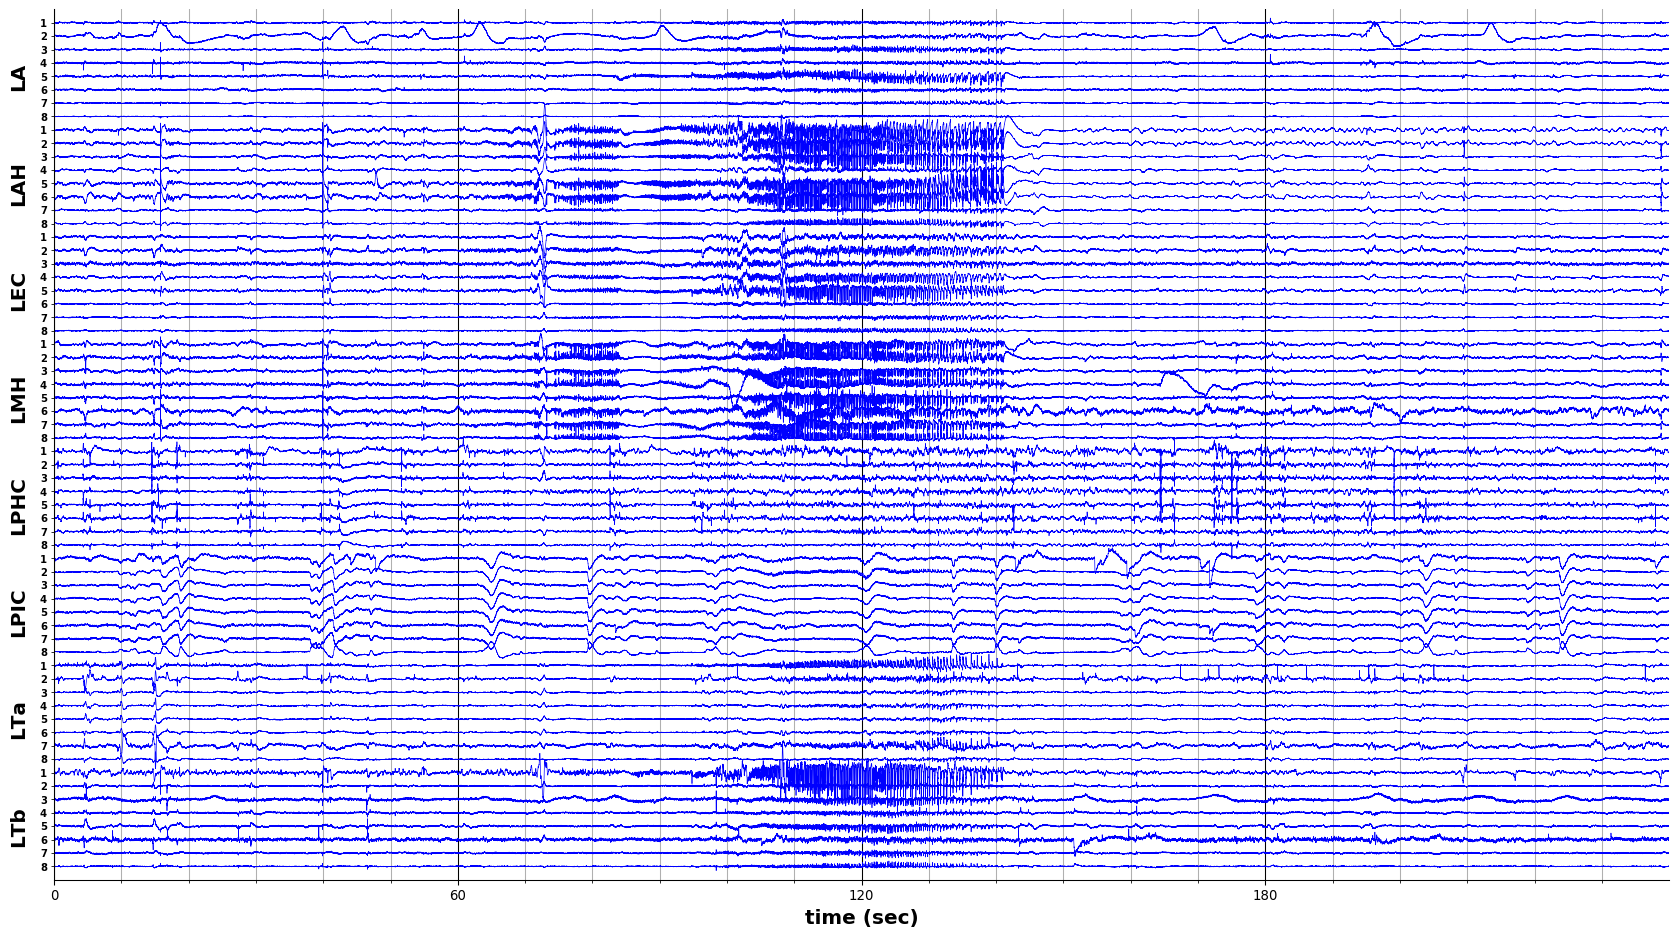

In [310]:
plot_reref_lfp(reref_lfp_matpath, offset=(30*60)-(70), duration=(4*60), mode='time', 
               save=True, title=False, label='', form='png')

### Figure 2

In [41]:
def get_sddata_from_dataframes(path_to_df, fext='.pkl',exclude_str=False):
    
    files = glob.glob(os.path.join(path_to_df,f'*{fext}'))
    
    if exclude_str:
        data_df = pd.concat([pd.read_pickle(fp) for fp in files if exclude_str not in fp],
                            ignore_index=True)
    else:
        data_df = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    
    #1) convert dataframe columns to numeric
    COLS_TO_CONVERT = ['sf', 'SO_sec', 'seizureinvaded', 'SO_index', 'sdinvaded_ch',
                     'sdonset_sec', 'sdend_sec', 'sdinvaded_region', 'seizuretermination_sec']
    
    for col in COLS_TO_CONVERT:
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce').fillna(0)
    
    #2) filter data by seizure and SD invaded
    szinvaded_index = data_df.index[data_df['seizureinvaded']==1]
    sdinvaded_index = data_df.index[(data_df['seizureinvaded']==1)&(data_df['sdinvaded_region']==1)]
    nonsdinvaded_index = data_df.index[(data_df['seizureinvaded']==1)&(data_df['sdinvaded_region']==0)]
    return data_df, szinvaded_index, sdinvaded_index, nonsdinvaded_index

In [315]:
def plotObject(nrChannels, myDpi=92, lenXax=1900, lenYax=1024, shareX=False, shareY=False):
    '''
    '''
    fig, axs = plt.subplots(nrChannels*2, 1, figsize=(lenXax/myDpi, lenYax/myDpi), sharex=shareX, sharey=shareY)
    gs = gridspec.GridSpec(nrChannels*2, 1, height_ratios=[1, 0.5]*(nrChannels))
    spines = ('top', 'right', 'bottom')
    for i in range(nrChannels*2):
        axs[i] = plt.subplot(gs[i])
        for sp in spines: 
            axs[i].spines[sp].set_visible(False)
        axs[i].tick_params(bottom=False, labelbottom=False)
    axs[i].spines[sp].set_visible(True)
    axs[i].tick_params(bottom=True, labelbottom=True)
    #remove spines
   
    fig.tight_layout()
    fig.subplots_adjust(hspace=.0)
    #fig.tight_layout()
    #plt.show()
    return fig, axs


def plot_sd_filtered_region(path, sd_onset_sec, sf=1000, sec_after=10, adjust_ms=150, order=2, cutoff=2, 
                            reg_list=None, figlabel=None, save=False, savepath=None, duration_sec=None):
    '''
    '''
    my_dpi = 92
    reref_path = adjustPathToLatestPreprocessingStep(path)
    _regions = get_region_name(path)
    
    if reg_list:
        regions = {k:v for k,v in _regions.items() if k in reg_list}
    else:
        regions = _regions
    del _regions
    
    _ = get_matfile_chnames(reref_path)
    chnames, matfiles = _[0], _[1]
    
    if not savepath:
        savepath = path
    
    #get matfiles grouped by region
    if 'macro' in path and 'reref' in reref_path:
        chnames_reref = [c for c in chnames if '8' not in c]
        matfiles_dic = {key : [matfiles[i] for i, ch in enumerate(chnames_reref) if ch in val] for key, val in regions.items()}
    else:
        matfiles_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] 
                            for key, val in regions.items()}
    
    all_regions = list(matfiles_dic.keys())

    if 'macro' in path:

        if os.path.basename(path) == '/':
            session_path = os.path.dirname(os.path.dirname(path))
        else:
            session_path = os.path.dirname(path)
        
        #print(session_path)
        pnr, sznr = get_patinfo_from_path(session_path)
    else:
        pnr, sznr = get_patinfo_from_path(path)
    
    ch_with_sd = {}
    for ix, reg in enumerate(all_regions):
        curr_reg = matfiles_dic[reg]
        data_in_reg = []
        #chnames_in_reg = []
        #get data
        for _, ch in enumerate(curr_reg):
            file = readMatfile(os.path.join(reref_path, ch))
            data_in_reg.append(file.reref_data[(sd_onset_sec*sf):(sd_onset_sec*sf)+(sec_after*sf)])

        #calculate delays
        wave_delays, sdchans_ix = get_wave_delays_per_wire(data_in_reg, 
                                               onset_adjust_ms=adjust_ms, 
                                               filter_order=order, 
                                               lpf_cutoff_fr_hz=cutoff)
        ch_with_sd[reg] = [curr_reg[i] for i in sdchans_ix]
        #sort indices
        indices = np.argsort(wave_delays)
        indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
        #print(indices)

        #plot results
        tabcols = list(mcolors.TABLEAU_COLORS.keys())
        plt.figure(figsize=(10,6))

        for i, ind in enumerate(data_in_reg):
            curr_data = ind
            res = butter_lowpass_filter(curr_data, cutoff, sf, order=order)
            curr_data = res[:sec_after*sf]
            plt.plot(curr_data, c='gray')


        for i, ind in enumerate(indices[:]):
            color = tabcols[i+1]

            curr_data = data_in_reg[ind]#[:2000]
            res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
            curr_data = res[:sec_after*sf]
            xdot = int(wave_delays[ind])
            plt.plot(curr_data, c='k' )
            plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms', c='k')
            #plt.legend()
        plt.xlabel('time (ms)')
        plt.ylabel('voltage (uV)')

        plt.title(reg+ ' low-pass filtered')
        if duration_sec:
            plt.axvline(int(duration_sec*sf), color='k', linewidth=1 )
        if save:
            spath = os.path.join(savepath, 'plots_sd_regions')

            if not os.path.exists(spath):
                print(f'creating path for saving: {spath}')
                os.mkdir(spath)

            figname= f'{reg}_sd_determiation'

            if figlabel:
                figname += figlabel
                
            plt.gca().spines['top'].set_visible(False) 
            plt.gca().spines['right'].set_visible(False)
            plt.savefig(os.path.join(spath, figname+'.png'), format='png', dpi=600, transparent=True)
            print(f'saving plot {figname} in {spath}')
        #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
        plt.gca().spines['top'].set_visible(False) 
        plt.gca().spines['right'].set_visible(False) 
        
        plt.show()
        

        #print(f'channels with SD: {indices}')
        #print(f'mean: {np.nanmean(wave_delays[indices])} ms')
    return wave_delays, ch_with_sd

### get data


In [311]:
dpath = '/media/Seizures/Wenzel/dataframes_patpool/'
data_df, szinv, sdinv, nonsdinv = get_sddata_from_dataframes(dpath, exclude_str='100')
invaded_df = data_df.loc[szinv]

data_df['sdinvaded_region'] = pd.to_numeric(data_df['sdinvaded_region'], errors='coerce').fillna(0)
invaded_df['sdinvaded_region'] = pd.to_numeric(invaded_df['sdinvaded_region'], errors='coerce').fillna(0)

In [312]:
data_df = data_df[(data_df['pnr']=='092')&(data_df['sznr']=='03')]

In [313]:
data_df[data_df['region'] == 'LAH']['fname']

584     CSC9.ncs
585    CSC10.ncs
586    CSC11.ncs
587    CSC12.ncs
588    CSC13.ncs
589    CSC14.ncs
590    CSC15.ncs
591    CSC16.ncs
Name: fname, dtype: object

In [314]:
data_df[data_df['region'] == 'LAH']['sdonset_sec']

584    1871.0
585    1871.0
586       0.0
587       0.0
588    1871.0
589    1871.0
590       0.0
591       0.0
Name: sdonset_sec, dtype: float64

saving plot LAH_sd_determiation in /media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/plots_sd_regions


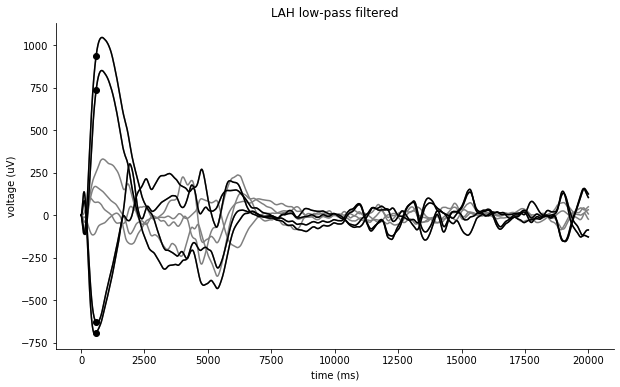

In [316]:
#roi = 'LAH'
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'
savepath='/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'

wd, idx_sd = plot_sd_filtered_region(path, 
                             sd_onset_sec=1871, 
                             sf=1000, 
                             sec_after=20, 
                             adjust_ms=500, 
                             order=2, 
                             cutoff=2, 
                             reg_list=['LAH'], 
                             figlabel=None, 
                             save=True, 
                             savepath=savepath,
                            duration_sec=False)

saving plot LMH_sd_determiation in /media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/plots_sd_regions


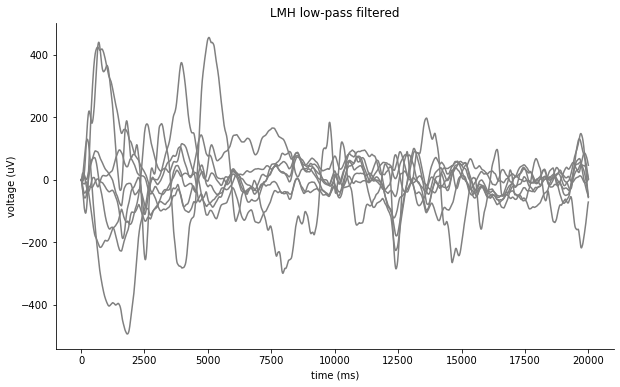

In [318]:
#roi = 'LAH'
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'
savepath='/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'

wd, idx_sd = plot_sd_filtered_region(path, 
                             sd_onset_sec=1871, 
                             sf=1000, 
                             sec_after=20, 
                             adjust_ms=1000, 
                             order=2, 
                             cutoff=2, 
                             reg_list=['LMH'], 
                             figlabel=None, 
                             save=True, 
                             savepath=savepath,
                            duration_sec=False)

saving plot LEC_sd_determiation in /media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/plots_sd_regions


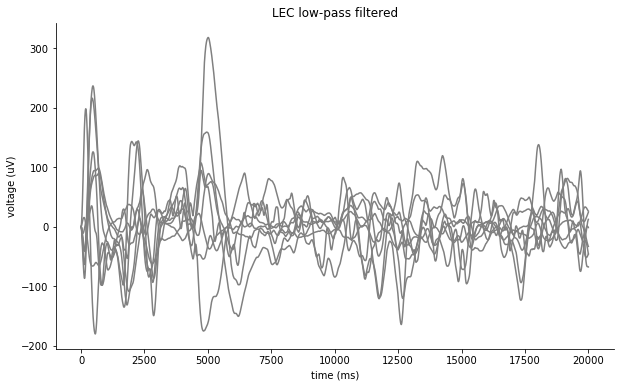

In [317]:
#roi = 'LAH'
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'
savepath='/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'

wd, idx_sd = plot_sd_filtered_region(path, 
                             sd_onset_sec=1871, 
                             sf=1000, 
                             sec_after=20, 
                             adjust_ms=500, 
                             order=2, 
                             cutoff=2, 
                             reg_list=['LEC'], 
                             figlabel=None, 
                             save=True, 
                             savepath=savepath,
                            duration_sec=False)

### Figure 3

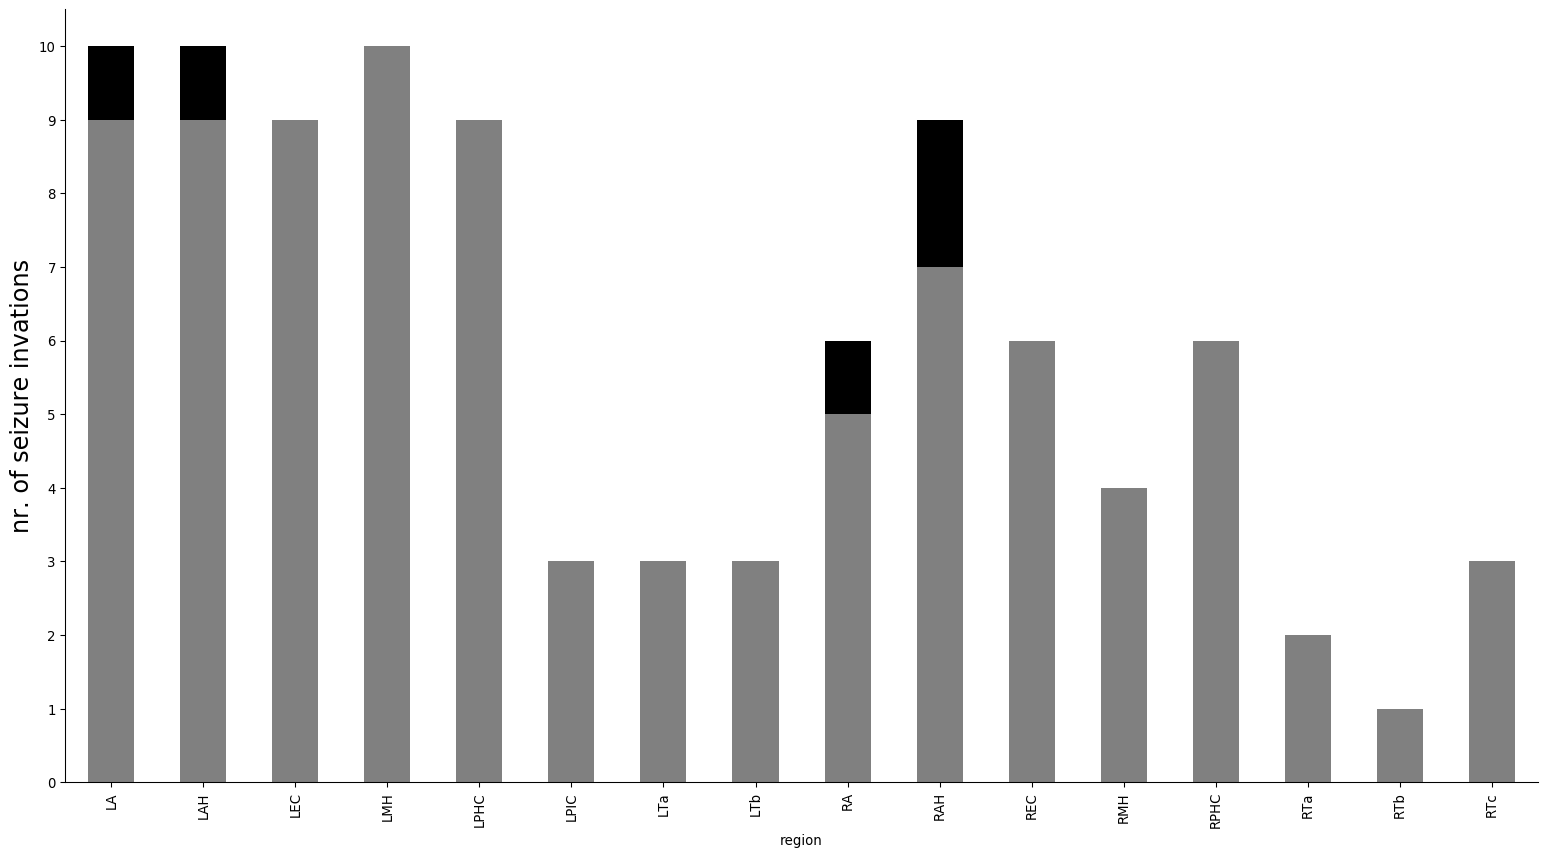

In [308]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
ax.grid(True)
percentage_df = invaded_df['sdinvaded_region'].groupby(invaded_df['region']).value_counts().unstack().fillna(0) /8
#subset.boxplot(column=['norm_mean_posictal'], 
#               by=['region'],  
#               ax=ax,
#              )
#percentage_df.plot(kind='bar', stacked=True, ax=ax)
bars = percentage_df.plot(kind='bar', stacked=True, ax=ax, color=['gray', 'black'])
# Set x-axis labels
group_labels = percentage_df.index
ax.set_xticks(range(len(group_labels)))
ax.set_xticklabels(group_labels)
#sns.barplot(x='region', y='sd', data=grouped_data)
ax.set_yticks(np.arange(0,11))
ax.legend().set_visible(False)

ax.set_ylabel('nr. of seizure invations', fontsize=18)
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)
#plt.axhline(1, color='k', linewidth=1 )
plt.savefig(os.path.join(savepath, 'nr_sd_occurance_region.png'), format='png', dpi=600, transparent=True)
plt.show()

### Figure 4

In [2]:
def plotObject(nrRows=1, nrCols=1, nrSubjects=1, height_ratios=False, myDpi=92, lenXax=1900, lenYax=1024, shareX=False, shareY=False):
    '''
    '''
    nr_rows = nrRows*nrSubjects
    
    fig, axs = plt.subplots(nr_rows, nrCols, figsize=(lenXax/myDpi, lenYax/myDpi), sharex=shareX, sharey=shareY)
    if height_ratios:
        #print(hight_rations*nr_rows, nr_rows)
        gs = gridspec.GridSpec(nr_rows, nrCols, height_ratios=height_ratios*nrSubjects)
    else:
        gs = gridspec.GridSpec(nr_rows, nrCols)
    spines = ('top', 'right', 'bottom')
    
    for i in range(nr_rows):
        #if nr_rows==1:
        #    cur_ax = axs
        #else:
        #    curr_ax = axs[i]
        axs[i] = plt.subplot(gs[i])
        for sp in spines: 
            axs[i].spines[sp].set_visible(False)
        axs[i].tick_params(bottom=False, labelbottom=False)
    axs[i].spines[sp].set_visible(True)
    axs[i].tick_params(bottom=True, labelbottom=True)
    #remove spines
   
    fig.tight_layout()
    fig.subplots_adjust(hspace=.0)
    #fig.tight_layout()
    #plt.show()
    return fig, axs

In [320]:
dpath = '/media/Seizures/Wenzel/dataframes_patpool/'
data_df, szinv, sdinv, nonsdinv = get_sddata_from_dataframes(dpath, exclude_str='100')
invaded_df = data_df.loc[szinv]

data_df['sdinvaded_region'] = pd.to_numeric(data_df['sdinvaded_region'], errors='coerce').fillna(0)
invaded_df['sdinvaded_region'] = pd.to_numeric(invaded_df['sdinvaded_region'], errors='coerce').fillna(0)

load_df = data_df[(data_df['pnr']=='092')&(data_df['sznr']=='03')]
roi = 'LAH'
reg_df = load_df[load_df['region']==roi]

In [321]:
reg_df

,pnr,sznr,datapath,chname,region,hemisphere,sf,SO_sec,fname,seizureinvaded,seizuretermination_sec,SO_index,sdinvaded_ch,sdonset_sec,sdend_sec,sdinvaded_region
584,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH1,LAH,L,1000,1800,CSC9.ncs,1.0,1871.0,1800000.0,1.0,1871.0,1878.0,1.0
585,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH2,LAH,L,1000,1800,CSC10.ncs,1.0,1871.0,1800000.0,1.0,1871.0,1878.0,1.0
586,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH3,LAH,L,1000,1800,CSC11.ncs,1.0,1871.0,1800000.0,0.0,0.0,1878.0,1.0
587,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH4,LAH,L,1000,1800,CSC12.ncs,1.0,1871.0,1800000.0,0.0,0.0,1878.0,1.0
588,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH5,LAH,L,1000,1800,CSC13.ncs,1.0,1871.0,1800000.0,1.0,1871.0,1878.0,1.0
589,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH6,LAH,L,1000,1800,CSC14.ncs,1.0,1871.0,1800000.0,1.0,1871.0,1878.0,1.0
590,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH7,LAH,L,1000,1800,CSC15.ncs,1.0,1871.0,1800000.0,0.0,0.0,1878.0,1.0
591,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LAH8,LAH,L,1000,1800,CSC16.ncs,1.0,1871.0,1800000.0,0.0,0.0,1878.0,1.0


/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC9.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC10.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC11.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC12.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC13.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC14.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC15.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC16.ncs


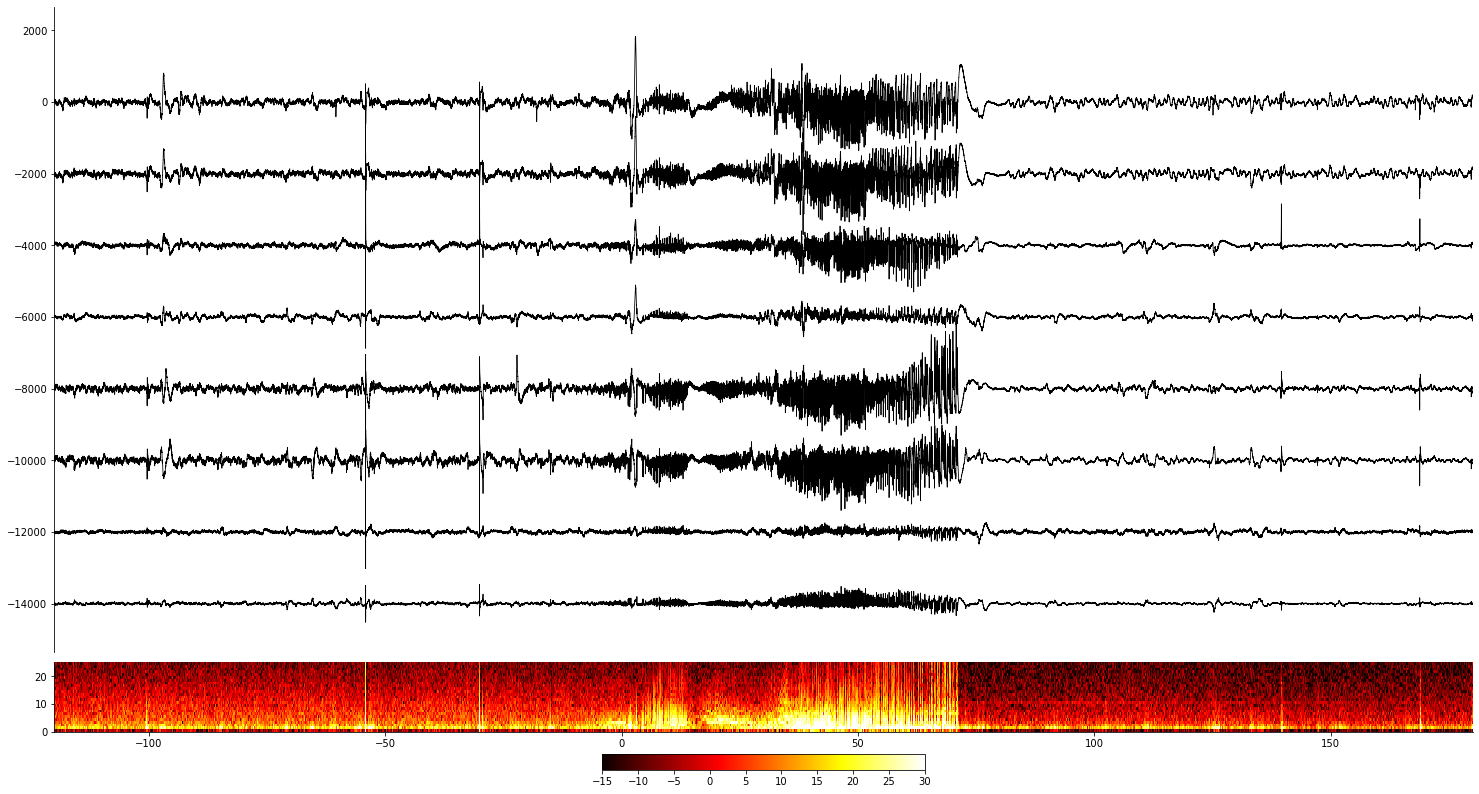

In [322]:
savepath='/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'
sec_before = 60+60
sec_after = (2*60)+60
sf = 1000
so_sec = 1800

fmin = 0
fmax = 25

counter = 0

# Create plot with three subplots
fig, ax = plotObject(nrRows=2, nrCols=1, nrSubjects=1, shareX=True, height_ratios=[3,0.5])
data_to_copy = {'chname' : [],
               'data' : [],
               'time_axis': [],
               'sf': []}
for i, ex in reg_df['datapath'].items():
    print(ex, reg_df['fname'][i])
    matfile = readMatfile(os.path.join(ex, f"{reg_df['fname'][i].split('.')[0]}_reref_data"))
    data = matfile.reref_data[(so_sec * sf) - (sec_before * sf):(so_sec * sf) + (sec_after * sf)]
    data_to_copy['chname'].append(reg_df['chname'][i])
    data_to_copy['data'].append(data)
    #_ = butter_lowpass_filter(data, 1, fs=sf, order=5)
    filt = butter_lowpass_filter(data, 0.8, fs=sf, order=5)
    timeax = np.linspace(-sec_before, sec_after, len(data))
    f_axis, t_axis, spg = spectrogram(data, fs=sf, nperseg=200, noverlap=150, scaling='density')
    dbspg = 10 * np.log10(spg[fmin:fmax, ])
    
    if counter == 0:
        mean_spg = dbspg
    else:
        old_spg = mean_spg
        mean_spg = np.asarray([np.nanmean([old_spg[ii], dbspg[ii]], axis=0) for ii, fr in enumerate(dbspg)])
        
    
    ax[0].plot(timeax, (data) - counter*2000, c='k', linewidth=0.8)
    #ax[0].plot(timeax, (filt) - counter*2000, c='k', linewidth=1.5)
        
    counter += 1
    
spec = ax[1].imshow(np.subtract(mean_spg, np.nanmean(mean_spg.flatten())), aspect='auto', cmap='hot', origin='lower',
                    extent=[sec_before * -1, sec_after, fmin, fmax], norm=Normalize(vmin=-15, vmax=30, clip=False))

ax[0].set_xlim(min(timeax), max(timeax))
#ax[0].set_yticks([])
#ax[0].spines['left'].set_visible(False)
fig.colorbar(spec, ax=ax[1], orientation='horizontal', pad=0.2)
plt.tight_layout()
plt.show()

data_to_copy['time_axis'].append(timeax)
data_to_copy['sf'].append(sf)

figname = f'{roi}_mean_spec'
figformat = 'png'
#savepath= '/media/Seizures/Wenzel/'

figoutname = os.path.join(savepath, '.'.join([figname, figformat]))

fig.savefig(figoutname,
            format=figformat,
            dpi=600,
            bbox_inches='tight',
           transparent=True)

In [323]:
dpath = '/media/Seizures/Wenzel/dataframes_patpool/'
data_df, szinv, sdinv, nonsdinv = get_sddata_from_dataframes(dpath, exclude_str='100')
invaded_df = data_df.loc[szinv]

data_df['sdinvaded_region'] = pd.to_numeric(data_df['sdinvaded_region'], errors='coerce').fillna(0)
invaded_df['sdinvaded_region'] = pd.to_numeric(invaded_df['sdinvaded_region'], errors='coerce').fillna(0)

load_df = data_df[(data_df['pnr']=='092')&(data_df['sznr']=='03')]
roi = 'LEC'
reg_df = load_df[load_df['region']==roi]

In [324]:
reg_df

,pnr,sznr,datapath,chname,region,hemisphere,sf,SO_sec,fname,seizureinvaded,seizuretermination_sec,SO_index,sdinvaded_ch,sdonset_sec,sdend_sec,sdinvaded_region
592,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC1,LEC,L,1000,1800,CSC17.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
593,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC2,LEC,L,1000,1800,CSC18.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
594,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC3,LEC,L,1000,1800,CSC19.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
595,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC4,LEC,L,1000,1800,CSC20.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
596,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC5,LEC,L,1000,1800,CSC21.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
597,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC6,LEC,L,1000,1800,CSC22.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
598,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC7,LEC,L,1000,1800,CSC23.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0
599,092,03,/media/Seizures/60min_cut/092/2021-09-21_08-52...,LEC8,LEC,L,1000,1800,CSC24.ncs,1.0,1874.0,1800000.0,0.0,0.0,0.0,0.0


/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC17.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC18.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC19.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC20.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC21.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC22.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC23.ncs
/media/Seizures/60min_cut/092/2021-09-21_08-52-50/DS_data/reref CSC24.ncs


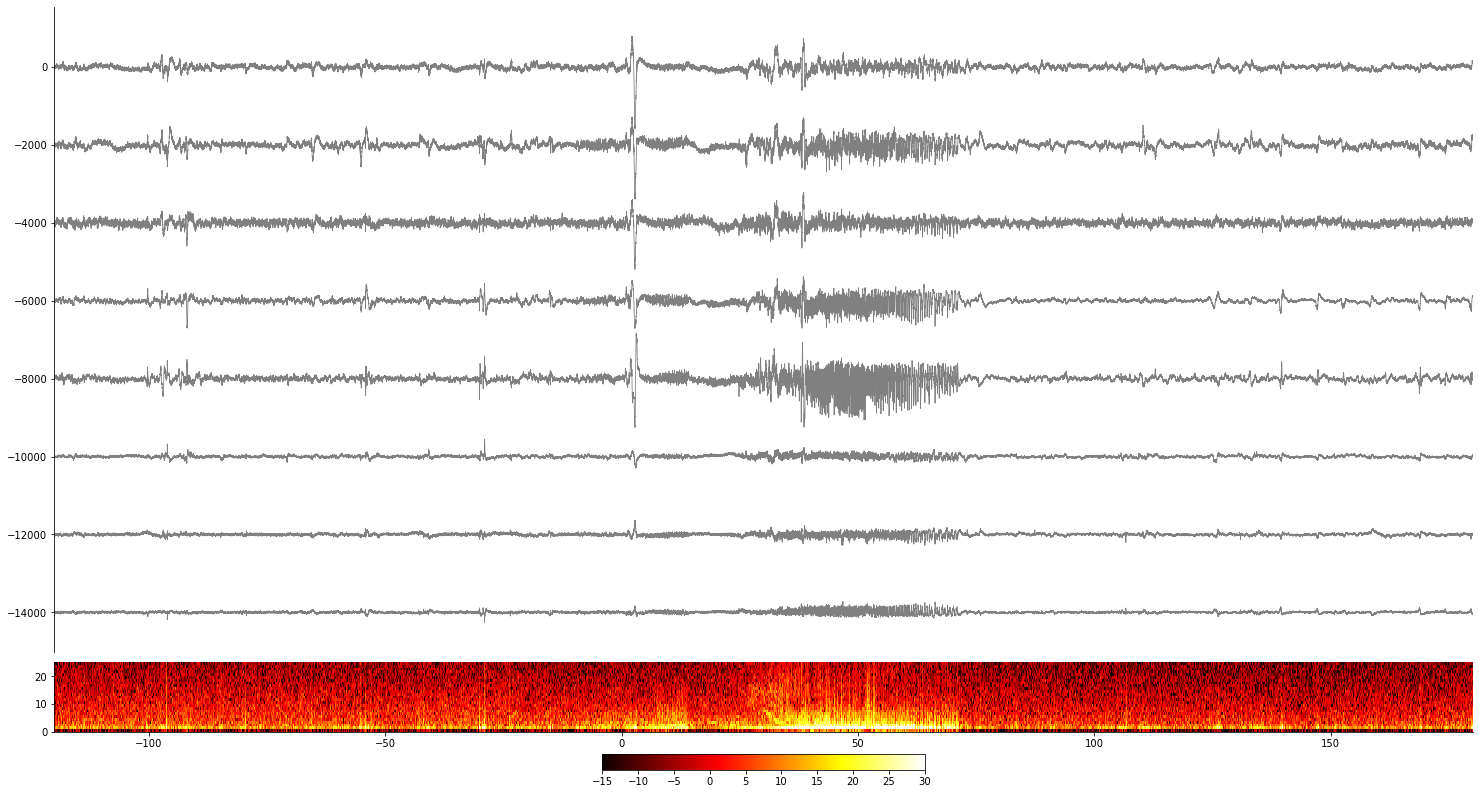

In [325]:
savepath='/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'
sec_before = 60+60
sec_after = (2*60)+60
sf = 1000
so_sec = 1800

fmin = 0
fmax = 25

counter = 0

# Create plot with three subplots
fig, ax = plotObject(nrRows=2, nrCols=1, nrSubjects=1, shareX=True, height_ratios=[3,0.5])
data_to_copy = {'chname' : [],
               'data' : [],
               'time_axis': [],
               'sf': []}
for i, ex in reg_df['datapath'].items():
    print(ex, reg_df['fname'][i])
    matfile = readMatfile(os.path.join(ex, f"{reg_df['fname'][i].split('.')[0]}_reref_data"))
    data = matfile.reref_data[(so_sec * sf) - (sec_before * sf):(so_sec * sf) + (sec_after * sf)]
    data_to_copy['chname'].append(reg_df['chname'][i])
    data_to_copy['data'].append(data)
    #_ = butter_lowpass_filter(data, 1, fs=sf, order=5)
    filt = butter_lowpass_filter(data, 0.8, fs=sf, order=5)
    timeax = np.linspace(-sec_before, sec_after, len(data))
    f_axis, t_axis, spg = spectrogram(data, fs=sf, nperseg=200, noverlap=150, scaling='density')
    dbspg = 10 * np.log10(spg[fmin:fmax, ])
    
    if counter == 0:
        mean_spg = dbspg
    else:
        old_spg = mean_spg
        mean_spg = np.asarray([np.nanmean([old_spg[ii], dbspg[ii]], axis=0) for ii, fr in enumerate(dbspg)])
        
    
    ax[0].plot(timeax, (data) - counter*2000, c='gray', linewidth=0.8)
    #ax[0].plot(timeax, (filt) - counter*2000, c='k', linewidth=1.5)
        
    counter += 1
    
spec = ax[1].imshow(np.subtract(mean_spg, np.nanmean(mean_spg.flatten())), aspect='auto', cmap='hot', origin='lower',
                    extent=[sec_before * -1, sec_after, fmin, fmax], norm=Normalize(vmin=-15, vmax=30, clip=False))

ax[0].set_xlim(min(timeax), max(timeax))
#ax[0].set_yticks([])
#ax[0].spines['left'].set_visible(False)
fig.colorbar(spec, ax=ax[1], orientation='horizontal', pad=0.2)
plt.tight_layout()
plt.show()

data_to_copy['time_axis'].append(timeax)
data_to_copy['sf'].append(sf)

figname = f'{roi}_mean_spec'
figformat = 'png'
#savepath= '/media/Seizures/Wenzel/'

figoutname = os.path.join(savepath, '.'.join([figname, figformat]))

fig.savefig(figoutname,
            format=figformat,
            dpi=600,
            bbox_inches='tight',
           transparent=True)

### Figure 4

In [3]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)

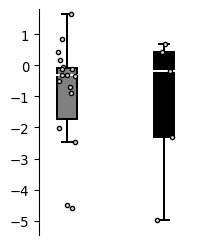

preictal_mean_normdb
non SD group is  not notmally distributed
pval 0.00040513218846172094
test type: MW
pval: 0.8569645457517311
significance: False False False
SD mean: -1.2649257591348524 STD: 2.1379421085366803
no SD mean: -1.3125128702209041 STD: 2.6075819603480053


In [443]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)


freq = 'broadband'
met = 'preictal_mean_normdb'
colors = ['gray', 'black']



subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2))

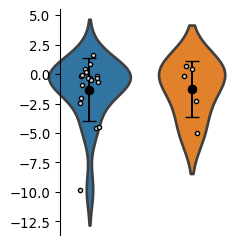

preictal_mean_normdb
non SD group is not normally distributed
pval 0.00040513218846172094
test type: MW
pval: 0.8569645457517311
significance: False False False
SD mean: -1.2649257591348524 STD: 2.1379421085366803
no SD mean: -1.3125128702209041 STD: 2.6075819603480053


In [12]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']

savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'

for i in metrics:
    files = glob.glob(os.path.join(spath, f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)

freq = 'broadband'
met = 'preictal_mean_normdb'
colors = ['gray', 'black']

subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region'] = subset['sdinvaded_region'].fillna(0)

# Choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

# Group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region'] == 1][freq]
g2 = grouped[grouped['sdinvaded_region'] == 0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

# Plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

# Create a violin plot with only edges colored
sns.violinplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, inner=None, linewidth=2, facecolor='None', edgecolor=colors)

# Overlay mean and standard deviation
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    region_data = grouped[grouped['sdinvaded_region'] == region][freq]
    
    mean = region_data.mean()
    std = region_data.std()
    
    # Plot mean
    ax.scatter(i, mean, color='black', zorder=3)
    
    # Plot standard deviation as error bars
    ax.errorbar(i, mean, yerr=std, color='black', fmt='o', capsize=5)

# Overlay a strip plot with explicit x-axis positions
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',  # White face
        edgecolor='black',  # Black edges
        s=10,               # Size of the points
        zorder=3            # Plot the points above the violin plot
    )

# Set axis labels and title
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom=False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', -15))

# Save or display the plot
#plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png', transparent=True, dpi=600)
plt.show()

# Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region'] == 1][freq]
g2 = grouped[grouped['sdinvaded_region'] == 0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is not normally distributed')
    print('pval', normality_g1.pvalue)

if not g2_normal:
    print('non SD group is not normally distributed')
    print('pval', normality_g2.pvalue)

if not(g1_normal == True) or not(g2_normal == True):
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())

print('test type:', test_type)
print('pval:', pval)
print('significance:', pval < 0.05, pval < 0.01, pval < 0.001)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2))


In [7]:
g1

5    -2.316145
6    -0.171520
9     0.441086
12    0.699532
18   -4.977582
Name: broadband, dtype: float64

In [371]:
normality_g2 = stats.shapiro(g2)
print('group is normal:',not normality_g2.pvalue <0.01)

group is normal: False


In [366]:
normality_g1 = stats.shapiro(g1)
print('group is normal:',not normality_g1.pvalue <0.01)

group is normal: True


In [369]:
(not normality_g1.pvalue <0.01) and (not normality_g2.pvalue <0.01)

False

In [340]:
statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
pval

0.8569645457517311

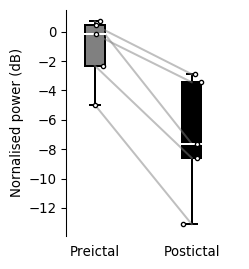

Comparing preictal_mean_normdb and postictal_mean_normdb, broadband
test type: Ttest
pval: 0.025898741270565448
Preictal mean: -1.2649257591348524 STD: 2.1379421085366803
Postictal mean: -7.134980218385751 STD: 3.7337160409125874


In [65]:
df = dict()

sd = 1

if sd== 0:
    sd_num = 0
    sd_name = 'notSD'
elif sd==1:
    sd_num = 1
    sd_name = 'SD'

spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']

savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'


for i in metrics:
    files = glob.glob(os.path.join(spath, f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)


freq = 'broadband'
colors = ['gray', 'black']
new_savepath = os.path.join(savepath, freq)

# Prepare the data
met_pre = 'preictal_mean_normdb'
met_post = 'postictal_mean_normdb'

# Filter for SD-invaded seizures
subset_pre = df[met_pre].copy()
subset_pre.replace([np.inf, -np.inf], np.nan, inplace=True)
subset_pre['sdinvaded_region'] = subset_pre['sdinvaded_region'].fillna(0)

# Apply the mask to filter only SD-invaded seizures
mask_pre = subset_pre.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset_pre = subset_pre[mask_pre]

subset_post = df[met_post].copy()
subset_post.replace([np.inf, -np.inf], np.nan, inplace=True)
subset_post['sdinvaded_region'] = subset_post['sdinvaded_region'].fillna(0)

mask_post = subset_post.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset_post = subset_post[mask_post]

# Filter for only SD-invaded regions
region_mask_pre = subset_pre['sdinvaded_region'] == sd_num
subset_pre = subset_pre[region_mask_pre]

region_mask_post = subset_post['sdinvaded_region'] == sd_num
subset_post = subset_post[region_mask_post]

# Group the data for each metric
grouped_pre = subset_pre.groupby(['pnr', 'sznr', 'region']).mean().reset_index()
grouped_post = subset_post.groupby(['pnr', 'sznr', 'region']).mean().reset_index()


# Merge the two metrics on ['pnr', 'sznr', 'region']
grouped_merged = pd.merge(grouped_pre, grouped_post, on=['pnr', 'sznr', 'region'], suffixes=('_pre', '_post'))

# Drop rows with missing data
grouped_merged.dropna(subset=[f'{freq}_pre', f'{freq}_post'], inplace=True)

# Create a long-format DataFrame for seaborn
melted = pd.melt(grouped_merged, id_vars=['pnr', 'sznr', 'region'], value_vars=[f'{freq}_pre', f'{freq}_post'],
                 var_name='Condition', value_name='Value')

# Plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops': {'edgecolor': 'black'},
    'medianprops': {'color': 'white'},
    'whiskerprops': {'color': 'black'},
    'capprops': {'color': 'black'}
}

# Create a box plot with matched width of strip plot
sns.boxplot(x='Condition', y='Value', data=melted, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)

# Overlay jittered points using plt.scatter for each condition
for i, condition in enumerate(['preictal', 'postictal']):
    if condition == 'preictal':
        condition_data = melted[melted['Condition'] == f'{freq}_pre']
    else:
        condition_data = melted[melted['Condition'] == f'{freq}_post']
    
    # Get the x-axis position for each condition
    x_vals = np.full(condition_data.shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        condition_data['Value'],
        color='white',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )

# Draw lines connecting paired samples
for _, row in grouped_merged.iterrows():
    plt.plot([0, 1], [row[f'{freq}_pre'], row[f'{freq}_post']], color='gray', alpha=0.5)
    
# Set axis labels and title
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Nornalised power (dB)', fontsize=10)
ax.set_xticklabels(['Preictal', 'Postictal'], fontsize=10)
plt.tick_params(bottom=False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', -15))

# Save or display the plot
#plt.savefig(os.path.join(new_savepath, f'{sd_name}_{freq}_{met_pre}_vs_{met_post}.eps'), format='eps', transparent=True, dpi=600)
plt.show()

# Run paired statistics
print(f'Comparing {met_pre} and {met_post}, {freq}')

g1 = grouped_merged[f'{freq}_pre'].dropna()
g2 = grouped_merged[f'{freq}_post'].dropna()



normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('Preictal group is not normally distributed')
    print('pval', normality_g1.pvalue)

if not g2_normal:
    print('Postictal group is not normally distributed')
    print('pval', normality_g2.pvalue)

if not(g1_normal == True) or not(g2_normal == True):
    test_type = 'MWU'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())

print('test type:', test_type)
print('pval:', pval)
#print('significance:', pval < 0.05, pval < 0.01, pval < 0.001)
print('Preictal', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('Postictal', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2))

outdic = {'preictal': g1.tolist(),
         'postictal': g2.tolist()}

#savemat(os.path.join(new_savepath, f'{sd_name}_{freq}_{met_pre}_vs_{met_post}.mat'), outdic)

In [45]:
g1.tolist()

[-2.3161448694582227,
 -0.17151979794538957,
 0.4410857445927907,
 0.6995319230520254,
 -4.977581795915466]

94

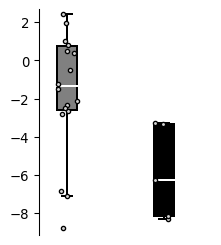

pospre_diff_normdb
test type: Ttest
pval: 0.018873419428233753
significance: True False False
SD mean: -5.870054459250899 STD: 2.2145095293832253
no SD mean: -1.3648692991502696 STD: 3.598699961492436


In [453]:
freq = 'broadband'
met = 'pospre_diff_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()


#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

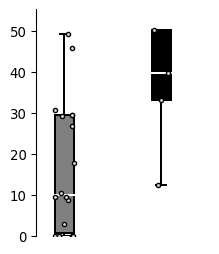

time_to_preictal_recovery_normdb
SD group is  not notmally distributed
pval 0.004417194984853268
non SD group is  not notmally distributed
pval 0.0197877399623394
test type: MW
pval: 0.01491382931598939
significance: True False False
SD mean: 84.86985827597469 STD: 102.58820736063139
no SD mean: 16.697427586166736 STD: 15.833321484606138


In [445]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'


for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)

freq = 'broadband'
met = 'time_to_preictal_recovery_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

#subset[freq] = subset[freq].clip(lower=0)

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()
grouped[freq] = grouped[freq].clip(lower=0)


g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()


#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

In [413]:
g2

0      46.047177
1      -0.223713
2      17.774852
3      -5.583190
4      49.342212
7      26.922216
8       2.924552
10     29.672825
11   -283.192454
13     29.404777
14     30.718053
15     29.505803
16     -7.720918
17      9.397446
19     10.588051
20    -13.572117
21      8.738641
22      9.517091
Name: broadband, dtype: float64

In [419]:
g2

0     46.047177
1      0.000000
2     17.774852
3      0.000000
4     49.342212
7     26.922216
8      2.924552
10    29.672825
11     0.000000
13    29.404777
14    30.718053
15    29.505803
16     0.000000
17     9.397446
19    10.588051
20     0.000000
21     8.738641
22     9.517091
Name: broadband, dtype: float64

In [405]:
stats.mannwhitneyu(g1.dropna(), g2.dropna())

MannwhitneyuResult(statistic=68.0, pvalue=0.09432672590567327)

In [407]:
stats.ttest_ind(g1.dropna(), g2.dropna())

Ttest_indResult(statistic=2.1337664428813032, pvalue=0.04481665511381194)

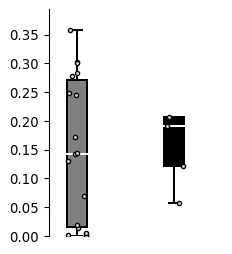

fit_rate_normdb
non SD group is  not notmally distributed
pval 0.033800989389419556
test type: MW
pval: 0.587357722369164
significance: False False False
SD mean: 0.2176302524136136 STD: 0.15629101031119574
no SD mean: 0.1508809150246906 STD: 0.12296824151245092


In [452]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'


for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)

freq = 'broadband'
met = 'fit_rate_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset[freq] = subset[freq].clip(lower=0)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]


new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()
#grouped[freq] = grouped[freq].clip(lower=0)


g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
#plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()


#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

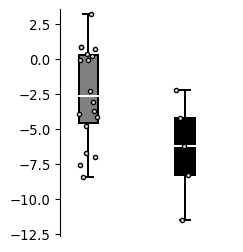

fit_offset_normdb
test type: Ttest
pval: 0.03554816861363522
significance: True False False
SD mean: -6.478860501675011 STD: 3.214895233472215
no SD mean: -2.5226873499317386 STD: 3.3594415733843035


In [447]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'

for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)


freq = 'broadband'
met = 'fit_offset_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
#subset[freq] = subset[freq].clip(upper=0)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]


new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()


#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

### Figure 5

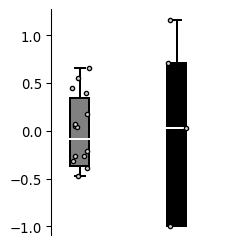

preictal_mean_normdb
non SD group is  not notmally distributed
pval 1.4109191397437826e-06
test type: MW
pval: 0.9138458795209368
significance: False False False
SD mean: -0.6211459003001061 STD: 1.8430353251244311
no SD mean: -0.7124393781597637 STD: 2.6284140861443963


In [448]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    

freq = 'high_gamma'
met = 'preictal_mean_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

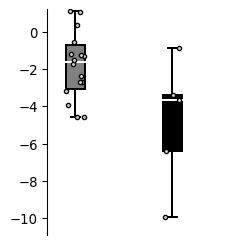

postictal_mean_normdb
non SD group is  not notmally distributed
pval 0.04902077466249466
test type: MW
pval: 0.11090968528039466
significance: False False False
SD mean: -4.848260674086498 STD: 3.0797383604813224
no SD mean: -1.8960785868462935 STD: 3.390934999466578


In [449]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    

freq = 'high_gamma'
met = 'postictal_mean_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

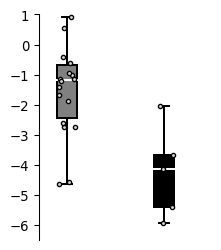

pospre_diff_normdb
non SD group is  not notmally distributed
pval 0.008647124283015728
test type: MW
pval: 0.004933281821153675
significance: True True False
SD mean: -4.2271147737863926 STD: 1.3650181044847547
no SD mean: -1.1836392086865297 STD: 2.243001139302199


In [450]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    

freq = 'high_gamma'
met = 'pospre_diff_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]
statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())
colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

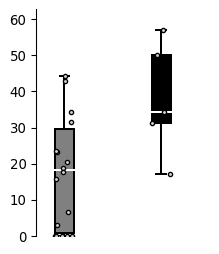

time_to_preictal_recovery_normdb
non SD group is  not notmally distributed
pval 1.7664111737758503e-06
test type: MW
pval: 0.07835605010084898
significance: False False False
SD mean: 37.97374757489483 STD: 14.159128643591476
no SD mean: 27.047155139327668 STD: 45.35881743259913


In [454]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    

freq = 'high_gamma'
met = 'time_to_preictal_recovery_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
#subset[freq] = subset[freq].clip(lower=0)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()
grouped[freq] = grouped[freq].clip(lower=0)


colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

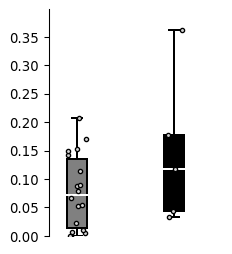

fit_rate_normdb
test type: Ttest
pval: 0.11552086554888882
significance: False False False
SD mean: 0.14723091978648398 STD: 0.1194504202107688
no SD mean: 0.0784337530418488 STD: 0.06365931476171892


In [442]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    

freq = 'high_gamma'
met = 'fit_rate_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
#subset[freq] = subset[freq].clip(lower=0)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()
grouped[freq] = grouped[freq].clip(lower=0)


colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )

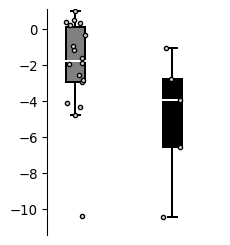

fit_offset_normdb
non SD group is  not notmally distributed
pval 0.009581979364156723
test type: MW
pval: 0.09432672590567327
significance: False False False
SD mean: -4.952340503838084 STD: 3.2567547339568907
no SD mean: -2.089742313859026 STD: 2.6310777746183045


In [441]:
df = dict()
spath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/'
#metrics = ['baseline_mean','preictal_mean','posictal_mean', 'posictal_diff_norm',
#               'fit_rate', 'fit_offset', 'time_to_preictal_recovery']

metrics = ['baseline_mean', 'baseline_mean_db', 'fit_offset', 'fit_offset_db', 'fit_rate', 'fit_rate_db', 
          'pospre_diff_normdb', 'pospre_diff', 'pospre_diff_db', 'postictal_mean', 'postictal_mean_db', 
          'postictal_mean_normdb', 'preictal_mean', 'preictal_mean_db', 'preictal_mean_normdb', 
           'time_to_baseline_recovery_normdb', 'time_to_baseline_recovery_db', 'time_to_baseline_recovery',
          'time_to_preictal_recovery_normdb', 'time_to_preictal_recovery_db', 'time_to_preictal_recovery',
          'fit_offset_normdb', 'fit_rate_normdb']

band_names = ['sub_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma', 'broadband']


savepath = '/media/Seizures/Wenzel/freq_analysis_dbnorm/plots_rome2024/'



for i in metrics:
    files = glob.glob(os.path.join(spath,f'{i}.pkl'))
    df_ = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
    df[i] = df_

for met, currdf in df.items():
    currdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    

freq = 'high_gamma'
met = 'fit_offset_normdb'
colors = ['gray', 'black']


subset = df[met]
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
#subset[freq] = subset[freq].clip(lower=0)
subset['sdinvaded_region']= subset['sdinvaded_region'].fillna(0)

#choose only seizures that are sd-invaded
mask = subset.groupby(['pnr', 'sznr'])['sdinvaded_region'].transform('max') == 1
subset = subset[mask]

new_savepath = os.path.join(savepath, freq)

if not os.path.exists(new_savepath):
    os.makedirs(new_savepath)

#group by region
grouped = subset.groupby(['pnr', 'sznr', 'region']).mean().reset_index()


colors = ['gray', 'black']

#plot
my_dpi = 96
fig, ax = plt.subplots(figsize=(250/my_dpi, 300/my_dpi), dpi=my_dpi)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

col = sns.light_palette((10, 60, 50), input="husl")

# Create a box plot with matched width of strip plot
sns.boxplot(x='sdinvaded_region', y=freq, data=grouped, ax=ax, showfliers=False, width=0.2, palette=colors,
           **PROPS)


whiskers = [item.get_ydata() for item in ax.lines if item.get_linestyle() == '-']
whiskers = np.array(whiskers).flatten()

# Min and max whisker values
min_whisker = whiskers.min()-(abs(0.1*whiskers.min()))
max_whisker = whiskers.max()+(abs(0.1*whiskers.max()))

# Overlay a strip plot with explicit x-axis positions
# Overlay a strip plot with white dots and black edges using plt.scatter
for i, region in enumerate(grouped['sdinvaded_region'].unique()):
    # Get the x-axis position for each region
    x_vals = np.full(grouped[grouped['sdinvaded_region'] == region].shape[0], i)
    
    # Jitter the x-values slightly to spread them out
    jittered_x = x_vals + np.random.uniform(-0.1, 0.1, size=len(x_vals))
    
    # Plot the points
    plt.scatter(
        jittered_x,
        grouped[grouped['sdinvaded_region'] == region][freq],
        color='lightgray',          # White face
        edgecolor='black',      # Black edges
        s=10,                   # Size of the points
        zorder=3                # Plot the points above the boxplot
    )
ax.set_ylim(min_whisker,max_whisker)
#ax.set_ylabel(f'{met}', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('', fontsize=18)
ax.set_xticklabels(['', ''], fontsize=10)
plt.tick_params(bottom = False)
ax.set_title('')

# Remove grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#fig.suptitle(freq)
ax.spines['left'].set_position(('outward', -15))  
# Place p-value text in the middle
#text_x = 0.5
#text_y = ax.get_ylim()[1] - abs(0.1*ax.get_ylim()[1])  # Adjust this value based on your preference
#plt.text(text_x, text_y, f'pval: {pval}', fontsize=18, ha='center')

# Save or display the plot
plt.savefig(os.path.join(new_savepath, f'{freq}_{met}.png'), format='png',transparent=True, dpi=600)
plt.show()

#Run statistics
print(met)

g1 = grouped[grouped['sdinvaded_region']==1][freq]
g2 = grouped[grouped['sdinvaded_region']==0][freq]

normality_g1 = stats.shapiro(g1)
normality_g2 = stats.shapiro(g2)

g1_normal = not(normality_g1.pvalue < 0.05)
g2_normal = not(normality_g2.pvalue < 0.05)

if not g1_normal:
    print('SD group is  not notmally distributed')
    print('pval' , normality_g1.pvalue)

if not g2_normal:
    print('non SD group is  not notmally distributed')
    print('pval' , normality_g2.pvalue)
#print('group is normal:',not normality.pvalue <0.01)

if not(g1_normal==True) or not(g2_normal==True):
    #print('g2 group is not normally distributed!')
    test_type = 'MW'
    statist, pval = stats.mannwhitneyu(g1.dropna(), g2.dropna())
else:
    test_type = 'Ttest'
    statist, pval = stats.ttest_ind(g1.dropna(), g2.dropna())



print('test type:', test_type)
print('pval:', pval)
print('significance:',  pval < 0.05, pval<0.01, pval<0.001)
#print(100 - (pval*100), pval < 0.05)
print('SD', 'mean:', np.nanmean(g1), 'STD:', np.nanstd(g1))
print('no SD', 'mean:', np.nanmean(g2), 'STD:', np.nanstd(g2) )